<a href="https://colab.research.google.com/github/anhpdd/geneal_tsp_150subang/blob/main/TSP_Gene_Algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install folium
!pip install plotly
!pip install osmnx
!pip install networkx
!pip install ortools
!pip install random
!pip install heapq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 26.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: Could not find a version that satisfies the requirement random (from versions: none)
ERROR: No matching distribution found for random
ERROR: Could not find a version that satisfies the requirement heapq (from versions: none)
ERROR: No matching distribution found for heapq


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import PolyLineTextPath
import plotly.express as px
import osmnx as ox
import networkx as nx
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2
import random
import heapq
import copy

In [ ]:
# Convert the 'Coordinates' column to a list of (lat, lon) tuples
def clean_coordinates(df_coordinates):
  coordinates = []
  for coord in df_coordinates:
    lat, lon = map(float, coord.strip('()').split(','))
    coordinates.append((lat, lon))
  return coordinates #the output is a list

In [ ]:
def extract_shortest_path_data(a, b):
    try:
        d = nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='length')
        path = nx.shortest_path(G, source=a, target=b, method='dijkstra', weight='length')
    except:
        d = np.nan
        path = []
    return d, path

In [ ]:
# Dijkstra's algorithm to find the shortest subpath between two cities
def dijkstra_shortest_path(start, end, distance_matrix):
    num_cities = len(distance_matrix)
    distances = [float('inf')] * num_cities
    distances[start] = 0
    previous = [None] * num_cities
    heap = [(0, start)]

    while heap:
        current_distance, current_city = heapq.heappop(heap)
        if current_city == end:
            break
        for neighbor in range(num_cities):
            if distance_matrix.iloc[current_city, neighbor] != float('inf'):
                new_distance = current_distance + distance_matrix.iloc[current_city, neighbor]
                if new_distance < distances[neighbor]:
                    distances[neighbor] = new_distance
                    previous[neighbor] = current_city
                    heapq.heappush(heap, (new_distance, neighbor))

    # Reconstruct the shortest path
    path = []
    current = end
    while current is not None:
        path.append(current)
        current = previous[current]
    path.reverse()
    return path if distances[end] != float('inf') else None

# Precompute mandatory subpaths
def precompute_mandatory_subpaths(distance_matrix):
    mandatory_subpaths = {}
    num_cities = len(distance_matrix)
    for i in range(num_cities):
        for j in range(num_cities):
            if i != j and distance_matrix.iloc[i, j] == float('inf'):
                subpath = dijkstra_shortest_path(i, j, distance_matrix)
                if subpath:
                    mandatory_subpaths[(i, j)] = subpath
    return mandatory_subpaths

# Fitness function with penalties for invalid routes
def fitness(chromosome, distance_matrix, mandatory_subpaths, penalty=1e6):
    total_distance = 0
    # Iterate over each leg of the journey (explicit route with return leg)
    for i in range(len(chromosome) - 1):
        city1 = chromosome[i]
        city2 = chromosome[i + 1]
        if (city1, city2) in mandatory_subpaths:
            subpath = mandatory_subpaths[(city1, city2)]
            for j in range(len(subpath) - 1):
                total_distance += distance_matrix.iloc[subpath[j], subpath[j + 1]]
        else:
            if distance_matrix.iloc[city1, city2] == float('inf'):
                total_distance += penalty  # Penalize invalid edges
            else:
                total_distance += distance_matrix.iloc[city1, city2]
    return 1 / total_distance  # Higher fitness for shorter routes

# Repair operator to enforce mandatory subpaths
def repair(chromosome, mandatory_subpaths):
    repaired = []
    for i in range(len(chromosome) - 1):
        city1 = chromosome[i]
        city2 = chromosome[i + 1]
        if (city1, city2) in mandatory_subpaths:
            subpath = mandatory_subpaths[(city1, city2)]
            repaired.extend(subpath[:-1])  # Add all but the last city
        else:
            repaired.append(city1)
    repaired.append(chromosome[-1])
    return repaired

# Crossover: Partially Mapped Crossover (PMX) modified for fixed start and end
def crossover(parent1, parent2):
    size = len(parent1)
    child = [None] * size
    child[0] = parent1[0]      # Keep the starting city fixed
    child[-1] = parent1[-1]    # Keep the ending city fixed (same as the starting city)
    # Choose crossover points from indices 1 to size-2
    start, end = sorted(random.sample(range(1, size - 1), 2))
    child[start:end] = parent1[start:end]

    for i in range(1, size - 1):
        if child[i] is None:
            for gene in parent2[1:size - 1]:
                if gene not in child:
                    child[i] = gene
                    break
    return child

# Mutation: Swap Mutation modified for fixed start and end
def mutate(chromosome, mutation_rate):
    if random.random() < mutation_rate:
        # Only swap genes that are not the first or last element
        idx1, idx2 = random.sample(range(1, len(chromosome) - 1), 2)
        chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]
    return chromosome

# Tournament selection method
def tournament_selection(population, distance_matrix, mandatory_subpaths, tournament_size):
    tournament = random.sample(population, tournament_size)
    return max(tournament, key=lambda x: fitness(x, distance_matrix, mandatory_subpaths))

# Genetic Algorithm for TSP
def genetic_algorithm_tsp(distance_matrix, population_size, generations, mutation_rate, crossover_rate, elitism_count, tournament_size):
    num_cities = len(distance_matrix)
    mandatory_subpaths = precompute_mandatory_subpaths(distance_matrix)

    # Initialize population with routes of the form:
    # [START_CITY] + permutation_of_remaining_cities + [START_CITY]
    # Start city = 0
    population = [
        [0] + random.sample(list(range(1, num_cities)), num_cities - 1) + [0]
        for _ in range(population_size)
    ]

    for generation in range(generations):
        # Sort population based on fitness (higher is better)
        population = sorted(
            population,
            key=lambda x: fitness(x, distance_matrix, mandatory_subpaths),
            reverse=True
        )
        new_population = population[:elitism_count]  # Elitism
        best_distance = 1 / fitness(population[0], distance_matrix, mandatory_subpaths)
        print(f"Generation {generation + 1} - Best Distance: {round(best_distance/1000, 2)} kms")

        while len(new_population) < population_size:
            # Use tournament selection to choose parents
            parent1 = tournament_selection(population, distance_matrix, mandatory_subpaths, tournament_size)
            parent2 = tournament_selection(population, distance_matrix, mandatory_subpaths, tournament_size)

            # Apply crossover with a probability defined by crossover_rate
            if random.random() < crossover_rate:
                child = crossover(parent1, parent2)
            else:
                # If no crossover, simply clone parent1
                child = copy.deepcopy(parent1)

            # Apply mutation
            child = mutate(child, mutation_rate)
            # Repair the chromosome if needed
            child = repair(child, mandatory_subpaths)
            new_population.append(child)

        population = new_population

    best_solution = max(population, key=lambda x: fitness(x, distance_matrix, mandatory_subpaths))
    best_distance = 1 / fitness(best_solution, distance_matrix, mandatory_subpaths)
    return best_solution, best_distance



In [ ]:
df=pd.read_csv('/content/drive/MyDrive/AI Group Project/random_coordinates_5km_radius.csv')
print("Number of Coordinates", len(df))
df.head(3)

Number of Coordinates 10000


,ID,Coordinates
0,1,"(3.0743266756494876, 101.61459382277468)"
1,2,"(3.044258088517577, 101.57248222510695)"
2,3,"(3.0783496394879464, 101.5746292436081)"


In [ ]:
# Specify depot (Starting point)
depot = (3.0575524381965606, 101.58387008316602)

# List out the coordinates
coords = [depot] + clean_coordinates(df['Coordinates'])[:100]

# Initialize the map
m = folium.Map(location=depot, tiles="cartodbpositron", zoom_start=12)

for indx, coord in enumerate(coords):
    # Create a color data
    if indx == 0:
        color = 'red'
    else:
        color = 'blue'
    folium.CircleMarker(location=coord, color = color, popup=f'Point {indx}', fill = True, radius=5).add_to(m)

m

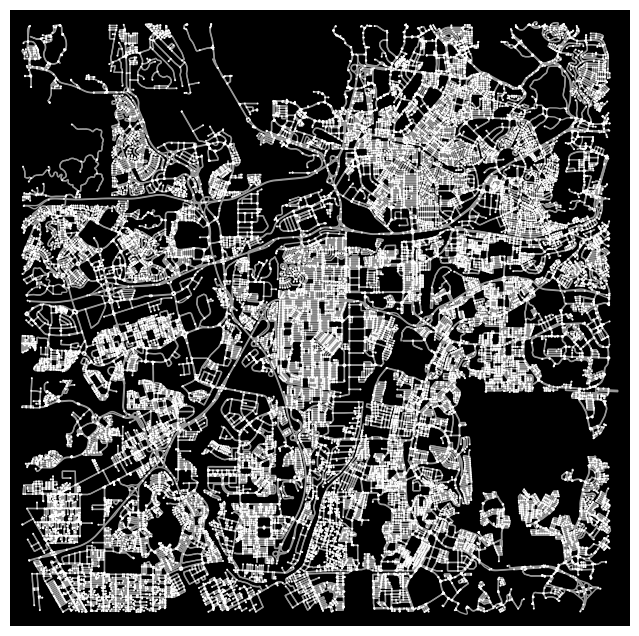

In [ ]:
# Map data generator
G=ox.graph_from_point(depot, dist=10000, network_type="drive")
G=ox.add_edge_speeds(G)
G=ox.add_edge_travel_times(G)
fig,ax = ox.plot_graph(G, bgcolor="black", node_size=2 , node_color="white", figsize=(16,8))

In [ ]:
# Convert coords to a DataFrame
coords_df = pd.DataFrame(coords, columns=['lat', 'lon'])
coords_df["node"] = coords_df.apply(lambda x: ox.distance.nearest_nodes(G, x['lon'], x['lat']), axis=1)

In [ ]:
# Specify the amount of cities
input = coords_df["node"][:150] # 150 cities

# Recalculate the distance matrix
distance_matrix_array = np.zeros((len(input), len(input)))
paths = []
for i, a in enumerate(input.tolist()):
    for j, b in enumerate(input.tolist()):
        distance, path = extract_shortest_path_data(a, b)
        distance_matrix_array[i, j] = distance
        paths.append({"Start Node": a, "End Node": b, "Start Pos":i, "End Pos":j ,"Path": path})

distance_matrix_array[np.isnan(distance_matrix_array)] = np.inf # Fill up NA values with number infinite
distance_matrix = pd.DataFrame(distance_matrix_array, columns=input.values, index=input.values) # Build a distance matrix dataframe
paths_df = pd.DataFrame(paths) # Build a dataframe for paths so we can access after the best route is found
paths_df

,Start Node,End Node,Start Pos,End Pos,Path
0,677382935,677382935,0,0,[677382935]
1,677382935,1197874483,0,1,"[677382935, 677382945, 677382922, 677382902, 6..."
2,677382935,678014417,0,2,"[677382935, 677382934, 677382931, 5327739780, ..."
3,677382935,5717179807,0,3,"[677382935, 677382934, 677382931, 5327739780, ..."
4,677382935,677922176,0,4,"[677382935, 677382934, 677382931, 5327739780, ..."
...,...,...,...,...,...
10196,2099180336,370714335,100,96,"[2099180336, 660840340, 660840262, 4897863979,..."
10197,2099180336,677618223,100,97,"[2099180336, 660840340, 660840262, 4897863979,..."
10198,2099180336,770066584,100,98,"[2099180336, 660840340, 660840262, 4897863979,..."
10199,2099180336,2210826388,100,99,"[2099180336, 660840340, 660840262, 4897863979,..."


In [ ]:
# Constants
population_size = 100
generations = 200
mutation_rate = 0.2
crossover_rate = 0.8      # Crossover will be applied with this probability
elitism_count = 5
tournament_size = 3
START_CITY = 0            # This is the first row value of the distance matrix

# Example of running the algorithm:
# 'distance_matrix_cleaned' should be a pandas DataFrame representing your TSP distances.
best_route, best_distance = genetic_algorithm_tsp(
    distance_matrix,
    population_size,
    generations,
    mutation_rate,
    crossover_rate,
    elitism_count,
    tournament_size
)

print("Best Route:", best_route)
print("Best Distance:", best_distance)

Generation 1 - Best Distance: 3743.53 kms
Generation 2 - Best Distance: 3738.64 kms
Generation 3 - Best Distance: 3712.24 kms
Generation 4 - Best Distance: 3712.24 kms
Generation 5 - Best Distance: 2716.4 kms
Generation 6 - Best Distance: 2716.4 kms
Generation 7 - Best Distance: 2716.4 kms
Generation 8 - Best Distance: 2706.6 kms
Generation 9 - Best Distance: 2698.62 kms
Generation 10 - Best Distance: 2679.63 kms
Generation 11 - Best Distance: 2679.63 kms
Generation 12 - Best Distance: 2679.63 kms
Generation 13 - Best Distance: 2679.63 kms
Generation 14 - Best Distance: 2662.47 kms
Generation 15 - Best Distance: 2659.64 kms
Generation 16 - Best Distance: 2659.64 kms
Generation 17 - Best Distance: 2642.93 kms
Generation 18 - Best Distance: 2642.93 kms
Generation 19 - Best Distance: 2634.82 kms
Generation 20 - Best Distance: 2634.82 kms
Generation 21 - Best Distance: 2634.82 kms
Generation 22 - Best Distance: 2630.35 kms
Generation 23 - Best Distance: 2623.24 kms
Generation 24 - Best Dis

In [ ]:
# Extract the coordinates of the best route
best_route_coords = [coords[i] for i in best_route]
best_path = [paths_df[(paths_df['Start Pos'] == best_route[i]) & (paths_df['End Pos'] == best_route[i + 1])]['Path'].values[0] for i in range(len(best_route) - 1)]

# Initialize the map
route_map = folium.Map(location=depot, tiles="cartodbpositron", zoom_start=12)

# Add the depot marker
folium.Marker(location=depot, popup='Depot', icon=folium.Icon(color='red')).add_to(route_map)

# Add markers for each point in the best route
for indx, coord in enumerate(best_route_coords):
    folium.CircleMarker(location=coord, popup=f'Point {indx}', color='blue', fill=True, radius=5).add_to(route_map)

route_map

In [ ]:
best_path1 = [path for path in best_path if path]  # Remove empty lists
for path in best_path1:  # Iterate over all routes
    ox.plot_graph_route(G, path, ax=ax, route_linewidth=4, route_alpha=0.7)

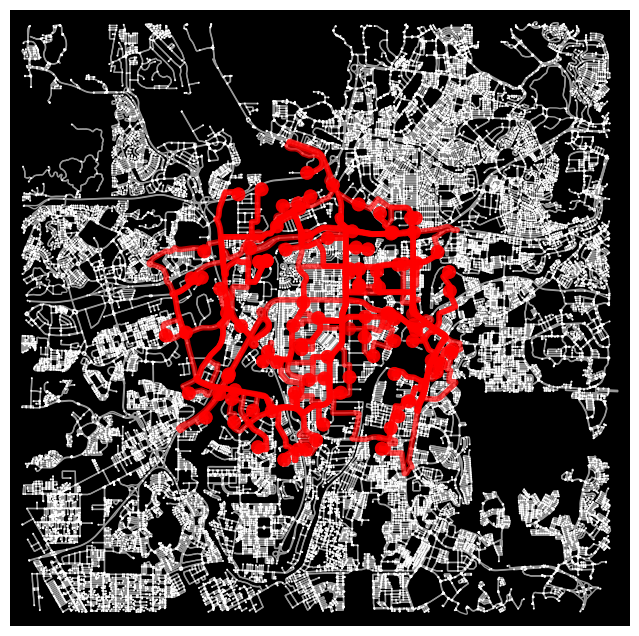

In [ ]:
display(fig)